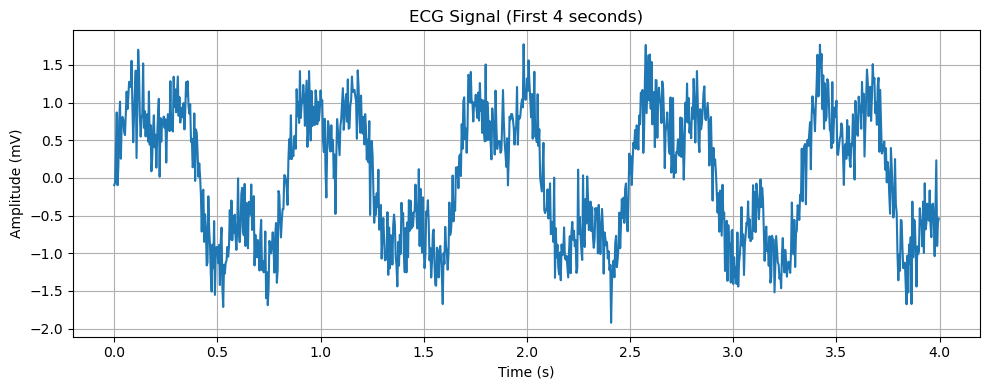

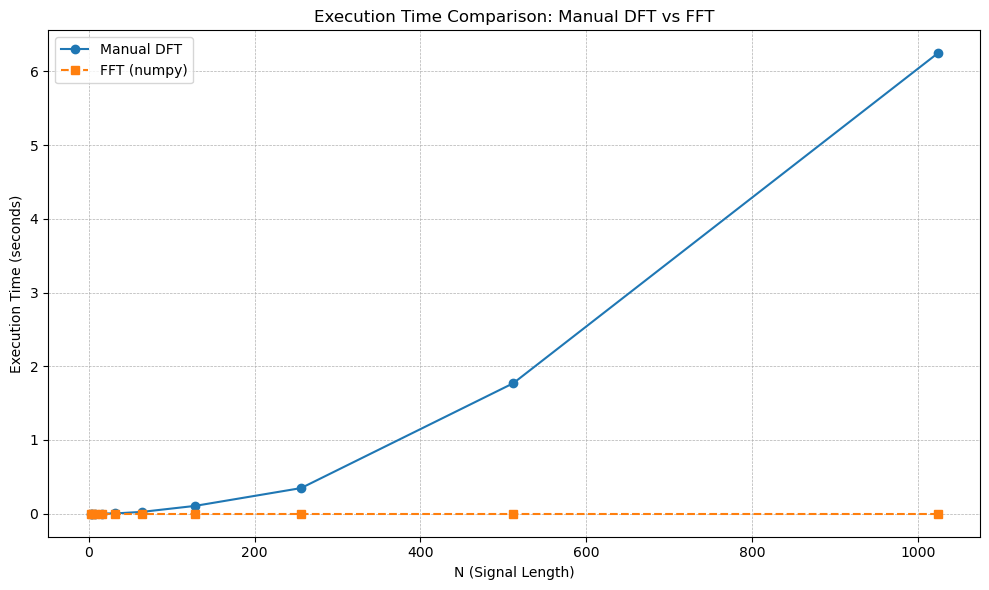

Manual DFT Time (N=128): 0.0752 s
FFT Time (N=128): 0.000000 s
DFT and FFT match: True


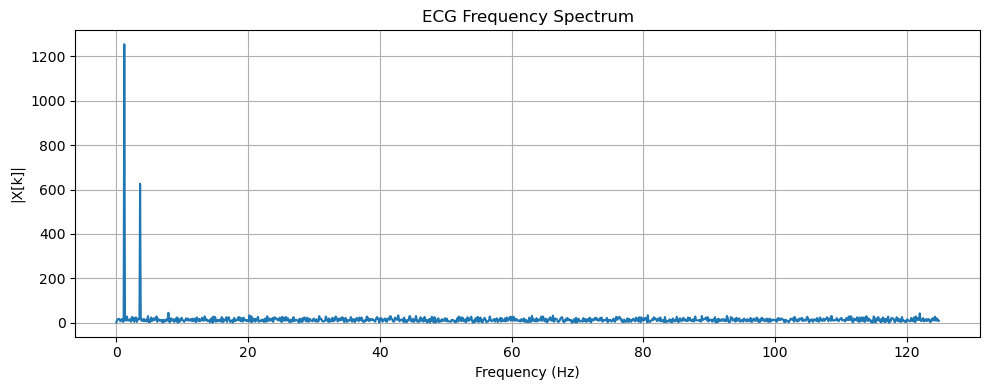

Estimated Heart Rate: 72.00 BPM


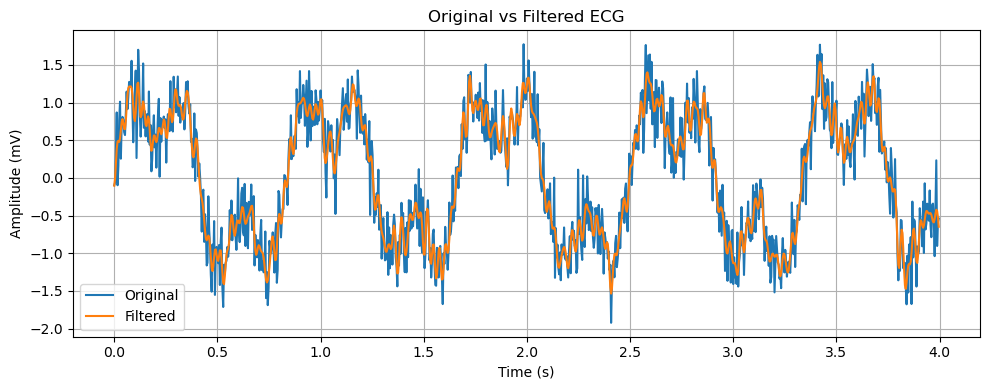

Time Domain Energy: 1797.2388
Freq Domain Energy: 1797.2388
Parseval's theorem holds: True


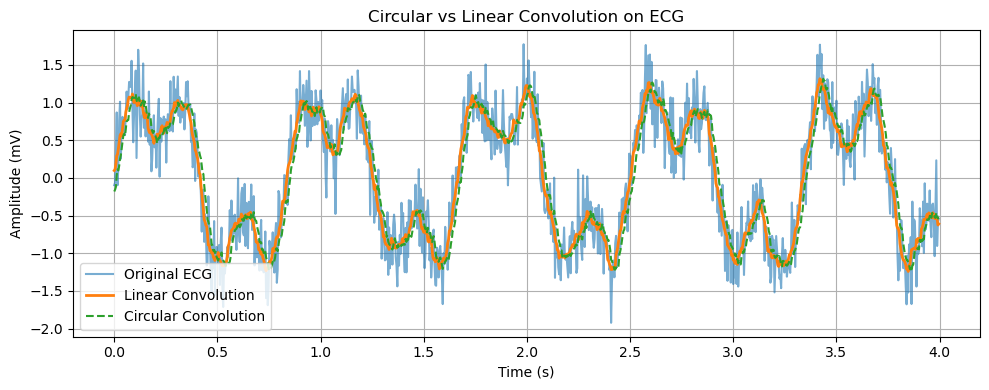

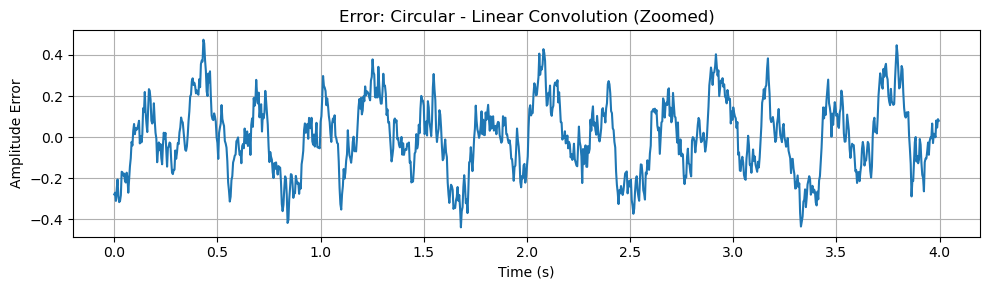

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import convolve
import time

# ------------------------------
# 1. Load ECG Signal from CSV
# ------------------------------
df = pd.read_csv('simulated_ecg_signal.csv')
t = df['Time (s)'].values
ecg = df['ECG (mV)'].values
Fs = int(1 / (t[1] - t[0]))  # Sampling frequency
N = len(ecg)

plt.figure(figsize=(10, 4))
plt.plot(t[:1000], ecg[:1000])
plt.title("ECG Signal (First 4 seconds)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (mV)")
plt.grid(True)
plt.tight_layout()
plt.show()

# ------------------------------
# 2. Manual DFT Function and Comparison
# ------------------------------
def manual_dft(x):
    N = len(x)
    X = np.zeros(N, dtype=complex)
    for k in range(N):
        for n in range(N):
            X[k] += x[n] * np.exp(-2j * np.pi * k * n / N)
    return X

# Values of N to test
N_values = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
manual_times = []
fft_times = []

# Measure execution times for both DFT and FFT
for N in N_values:
    x = ecg[:N]

    # Time manual DFT
    start = time.time()
    manual_dft(x)
    manual_times.append(time.time() - start)

    # Time FFT
    start = time.time()
    np.fft.fft(x)
    fft_times.append(time.time() - start)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(N_values, manual_times, marker='o', label='Manual DFT')
plt.plot(N_values, fft_times, marker='s', label='FFT (numpy)', linestyle='--')
#plt.yscale('log')
plt.xlabel('N (Signal Length)')
plt.ylabel('Execution Time (seconds)')
plt.title('Execution Time Comparison: Manual DFT vs FFT')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

N = len(ecg)

N_test = 128
x_small = ecg[:N_test]

start_manual = time.time()
X_manual = manual_dft(x_small)
end_manual = time.time()

start_fft = time.time()
X_fft = np.fft.fft(x_small)
end_fft = time.time()

print(f"Manual DFT Time (N=128): {end_manual - start_manual:.4f} s")
print(f"FFT Time (N=128): {end_fft - start_fft:.6f} s")
print("DFT and FFT match:", np.allclose(X_manual, X_fft, atol=1e-6))

# ------------------------------
# 3. Frequency Spectrum and Heart Rate
# ------------------------------
X = np.fft.fft(ecg)
freqs = np.fft.fftfreq(N, d=1/Fs)


plt.figure(figsize=(10, 4))
plt.plot(freqs[:N//2], np.abs(X[:N//2]))
plt.title("ECG Frequency Spectrum")
plt.xlabel("Frequency (Hz)")
plt.ylabel("|X[k]|")
plt.grid(True)
plt.tight_layout()
plt.show()

# Estimate heart rate from dominant frequency
spectrum = np.abs(X[:N//2])
#spectrum[0] = 0  # remove DC
peak_idx = np.argmax(spectrum)
dominant_freq = freqs[peak_idx]
bpm = dominant_freq * 60
print(f"Estimated Heart Rate: {bpm:.2f} BPM")

# ------------------------------
# 4. Frequency-Domain Filtering
# ------------------------------
cutoff = 40  # Hz
X_filtered = X.copy()
X_filtered[np.abs(freqs) > cutoff] = 0
ecg_filtered = np.fft.ifft(X_filtered).real

plt.figure(figsize=(10, 4))
plt.plot(t[:1000], ecg[:1000], label="Original")
plt.plot(t[:1000], ecg_filtered[:1000], label="Filtered")
plt.title("Original vs Filtered ECG")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (mV)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ------------------------------
# 5. Parseval's Theorem Verification
# ------------------------------
E_time = np.sum(ecg**2)
E_freq = (1/N) * np.sum(np.abs(X)**2)
print(f"Time Domain Energy: {E_time:.4f}")
print(f"Freq Domain Energy: {E_freq:.4f}")
print("Parseval's theorem holds:", np.allclose(E_time, E_freq, rtol=1e-4))

# ------------------------------
# 6. Circular Convolution with ECG
# ------------------------------
def circular_convolution(x, h):
    N = len(x)
    h_padded = np.pad(h, (0, N - len(h)), 'constant')
    y = np.zeros(N, dtype=complex)
    for n in range(N):
        for m in range(N):
            y[n] += x[m] * h_padded[(n - m) % N]
    return y.real

# Use moving average filter
h = np.ones(10) / 10
y_circ = circular_convolution(ecg, h)

# Linear convolution for comparison
y_lin = convolve(ecg, h, mode='same')

plt.figure(figsize=(10, 4))
plt.plot(t[:1000], ecg[:1000], label="Original ECG", alpha=0.6)
plt.plot(t[:1000], y_lin[:1000], label="Linear Convolution", linewidth=2)
plt.plot(t[:1000], y_circ[:1000], '--', label="Circular Convolution", linewidth=1.5)
plt.title("Circular vs Linear Convolution on ECG")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (mV)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Error due to circular wrap-around
error = y_circ - y_lin
plt.figure(figsize=(10, 3))
plt.plot(t[:1000], error[:1000])
plt.title("Error: Circular - Linear Convolution (Zoomed)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude Error")
plt.grid(True)
plt.tight_layout()
plt.show()


In [60]:
print(freqs)

[ 0.   0.1  0.2 ... -0.3 -0.2 -0.1]


<StemContainer object of 3 artists>

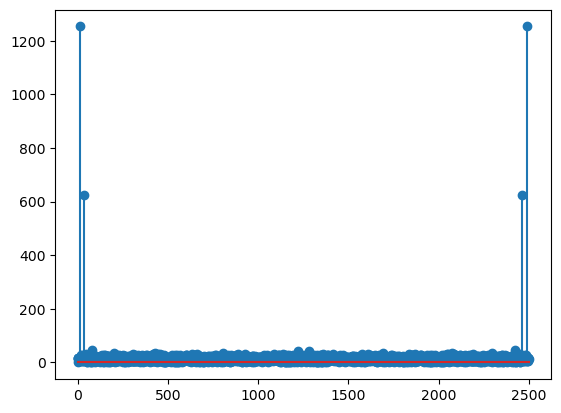

In [50]:
plt.stem(abs(X))

<StemContainer object of 3 artists>

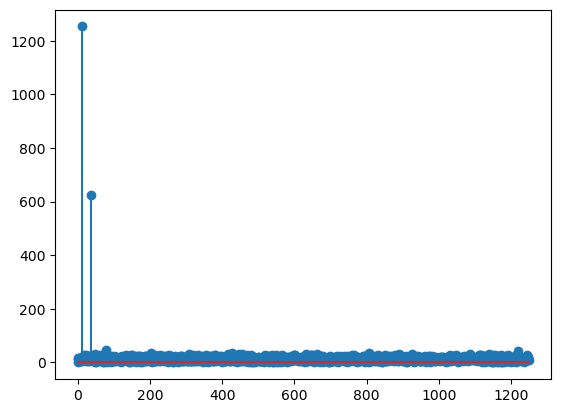

In [64]:
plt.stem(spectrum)

<StemContainer object of 3 artists>

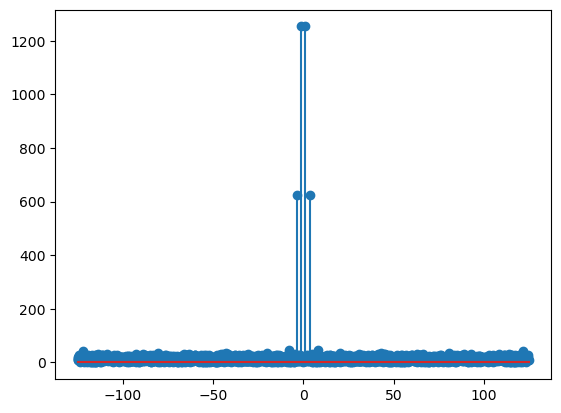

In [52]:
plt.stem(freqs,abs(X))

<StemContainer object of 3 artists>

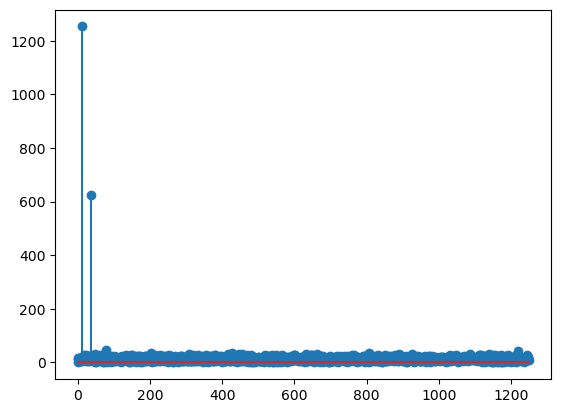

In [56]:
plt.stem(spectrum)

In [7]:
print(np.sum((ecg-ecg_filtered)**2))

153.2017937650656
